# Predicting NBA Wins in a Full Season

## Introduction

The goal of this exercise is to try and create a model that can accurately predict an expected win total for an NBA team given a specific statistic or set of statistics. To create this model we are going to be looking at the dataset taken from https://www.kaggle.com/open-source-sports/mens-professional-basketball/data. This data contains almost every raw statistic from every professional basketball game played from the year 1946 and on. By creating this model we are trying to accomplish something very important in the sports industry. By seeing which raw statistic best correlates with total wins we would be giving coaches, general managers...etc. very useful information to which they could build a team and/or gameplan around. This could give them target values such as how many assists per game is predicted for a certain win total and so on. 

## Cleaning the Data
Our data contains information about leagues outside of the National Basketball Association which are no longer active. For our model we want to use statistics specifically from the NBA, and for seasons that were played in their entire 82 form. For this reason we are eliminating all data from other leagues and from NBA seasons less than 82 games. In some of the extremely early seasons of our data we are missing a lot of information from certain statistics. We are eliminating these years altogether. 

In [606]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from math import sqrt
from sklearn import ensemble
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier , export_graphviz
from collections import Counter
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline

In [623]:
df = pd.read_csv('basketball_teams.csv')


In [624]:
dfNBA = df[df.lgID == 'NBA']#Using Only NBA information for our data
df = dfNBA[dfNBA.games == 82]#Using Only NBA seasons that played the full 82 games.

In [508]:
list(df)

['year',
 'lgID',
 'tmID',
 'franchID',
 'confID',
 'divID',
 'rank',
 'confRank',
 'playoff',
 'name',
 'o_fgm',
 'o_fga',
 'o_ftm',
 'o_fta',
 'o_3pm',
 'o_3pa',
 'o_oreb',
 'o_dreb',
 'o_reb',
 'o_asts',
 'o_pf',
 'o_stl',
 'o_to',
 'o_blk',
 'o_pts',
 'd_fgm',
 'd_fga',
 'd_ftm',
 'd_fta',
 'd_3pm',
 'd_3pa',
 'd_oreb',
 'd_dreb',
 'd_reb',
 'd_asts',
 'd_pf',
 'd_stl',
 'd_to',
 'd_blk',
 'd_pts',
 'o_tmRebound',
 'd_tmRebound',
 'homeWon',
 'homeLost',
 'awayWon',
 'awayLost',
 'neutWon',
 'neutLoss',
 'confWon',
 'confLoss',
 'divWon',
 'divLoss',
 'pace',
 'won',
 'lost',
 'games',
 'min',
 'arena',
 'attendance',
 'bbtmID']

In [625]:
df.drop(df.columns[[1,2,3,4,5,6,7,8,59,58,57,56,55,52,51,50,49,48,47,46,45,44,43,42,41,40]], axis=1, inplace=True)
#Replacing catergories we won't be using.

C:\Users\Connor\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [626]:
df=df[(df != 0).all(1)]
#Eliminating some of the early years which do not have complete statistics.

In [627]:
df['winning_season'] = df.won.apply(lambda x: 0 if x <42  else 1 )
#Converting our wins column to 1 or 0. 1 constitutes the team finished with a winning season (above .500 winning pct.)
#This is what our model will be trying to predict.

In [628]:
df['total_fg'] = df['o_fgm']-df['d_fgm']
df['total_asts'] =df['o_asts']-df['d_asts']
df['total_reb'] = df['o_reb']-df['d_reb']

#We are taking net totals for field goals,assists and rebounds to add as features. 

## Analyzing Data

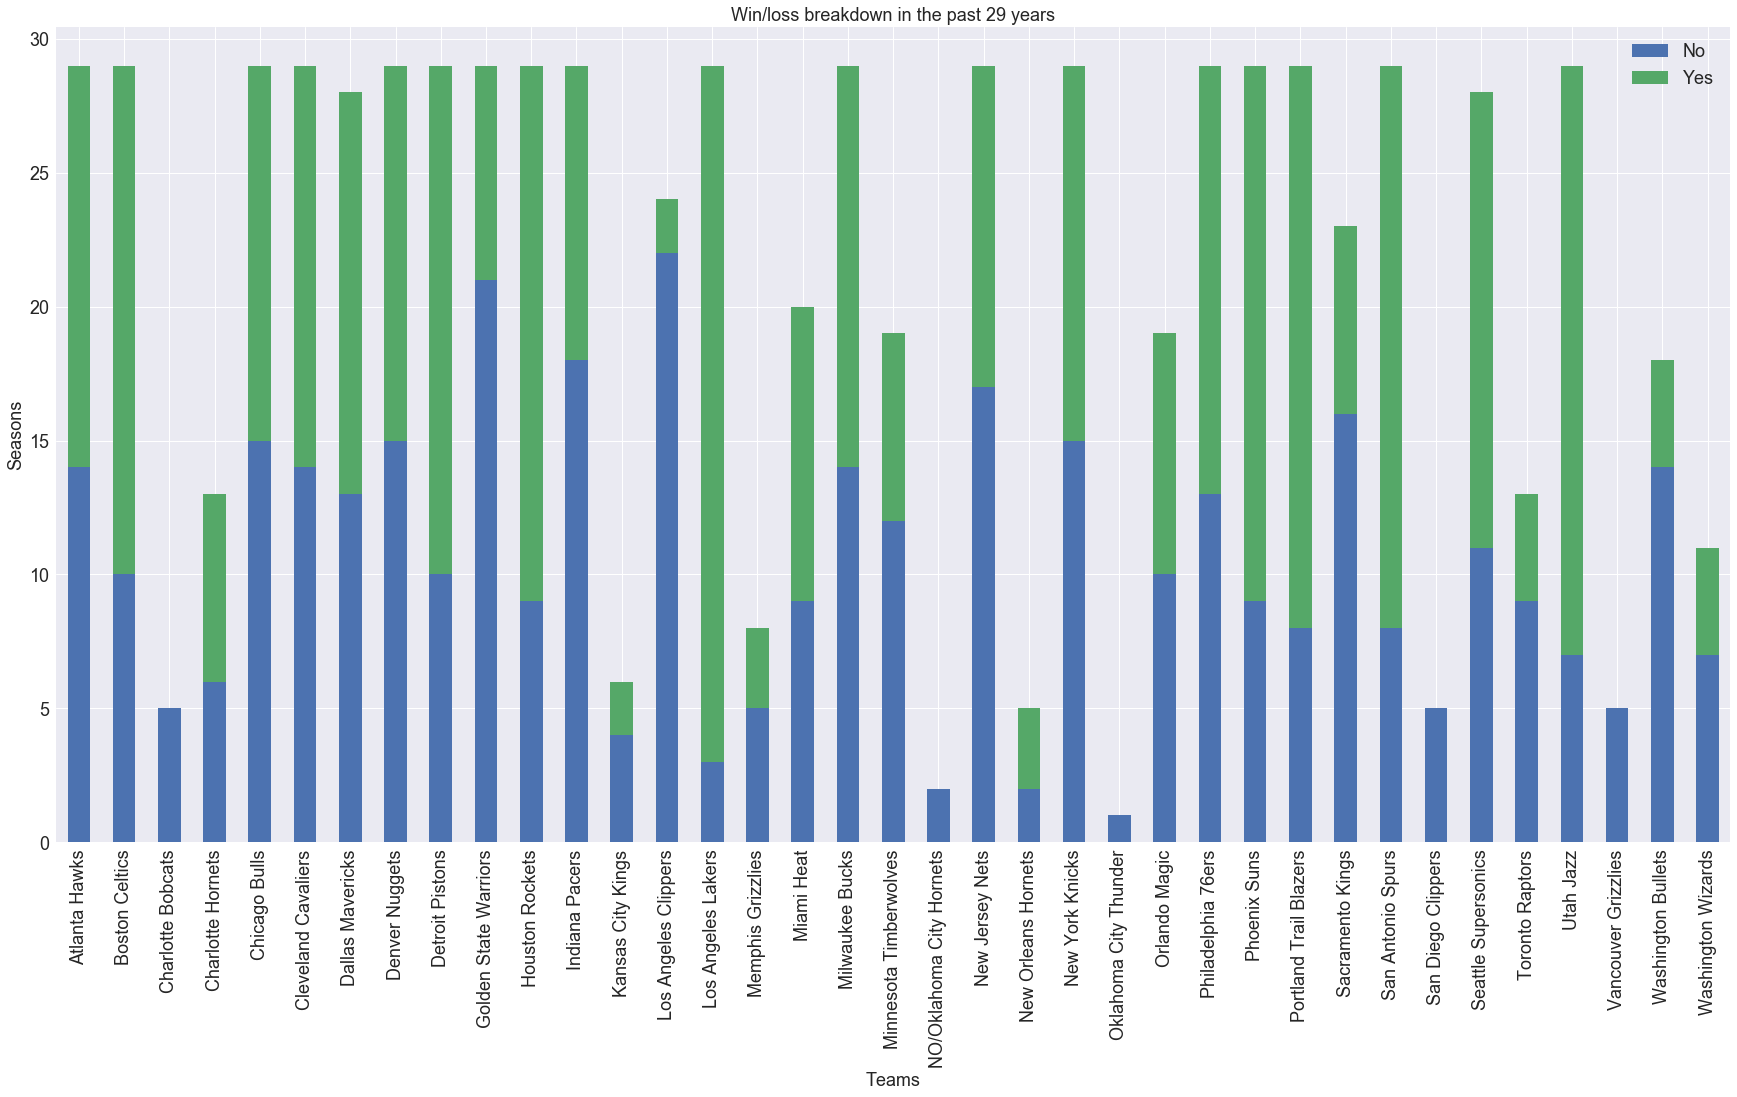

In [629]:
df1=df.groupby('name').winning_season.value_counts().unstack()
x=df1.fillna(0)
x.columns = ['No', 'Yes']
x.reset_index(inplace=True)
n=len(df['name'])
ind = np.arange(n)
ax=x[['No','Yes']].plot(kind='bar', stacked=True,figsize=(30,15))
ax.set_xlabel("Teams", fontsize=18)
ax.set_ylabel("Seasons", fontsize=18)
ax.set_xticklabels(x.name,fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title("Win/loss breakdown in the past 29 years",fontsize=18)


In [374]:
df.name.unique()

array(['Atlanta Hawks', 'Boston Celtics', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Denver Nuggets', 'Detroit Pistons',
       'Golden State Warriors', 'Houston Rockets', 'Indiana Pacers',
       'Kansas City Kings', 'Los Angeles Lakers', 'Milwaukee Bucks',
       'New Jersey Nets', 'New York Knicks', 'Philadelphia 76ers',
       'Phoenix Suns', 'Portland Trail Blazers', 'San Antonio Spurs',
       'San Diego Clippers', 'Seattle Supersonics', 'Utah Jazz',
       'Washington Bullets', 'Dallas Mavericks', 'Los Angeles Clippers',
       'Sacramento Kings', 'Charlotte Hornets', 'Miami Heat',
       'Minnesota Timberwolves', 'Orlando Magic', 'Toronto Raptors',
       'Vancouver Grizzlies', 'Washington Wizards', 'Memphis Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'NO/Oklahoma City Hornets', 'Oklahoma City Thunder'], dtype=object)

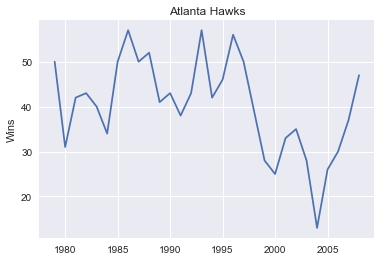

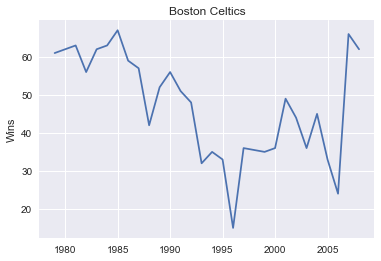

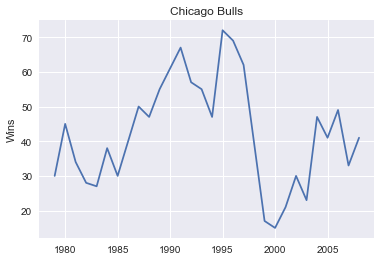

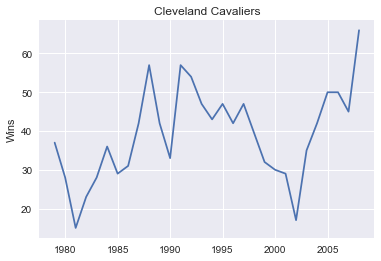

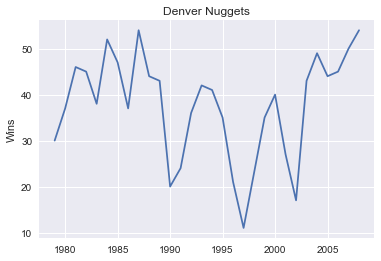

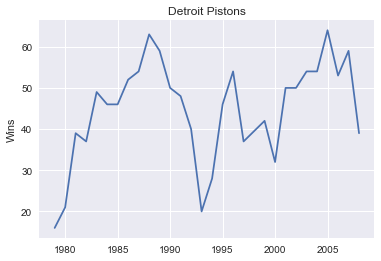

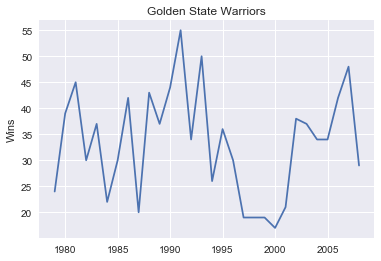

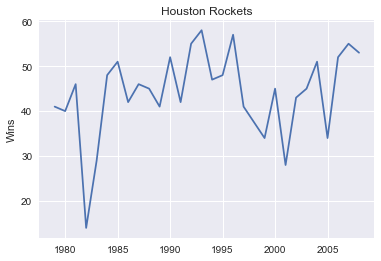

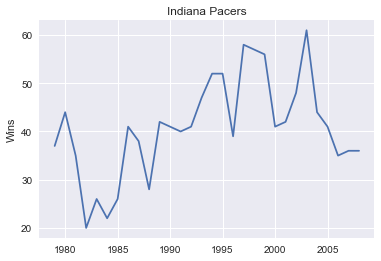

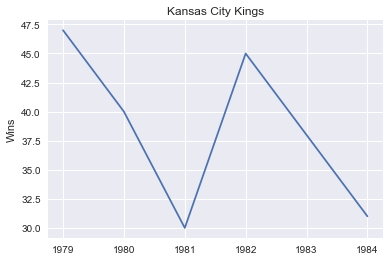

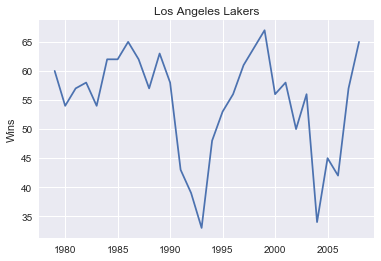

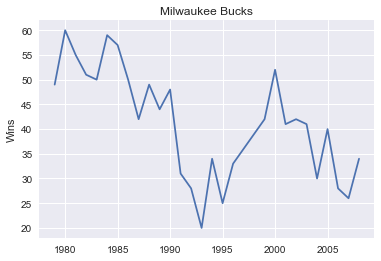

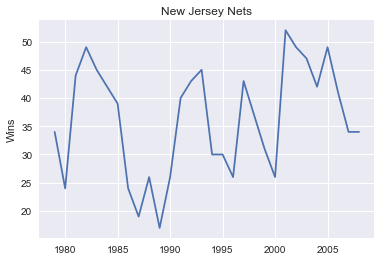

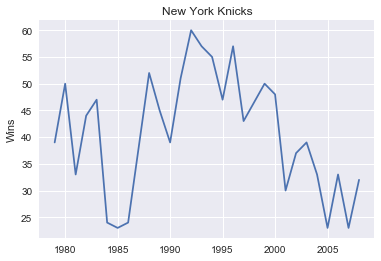

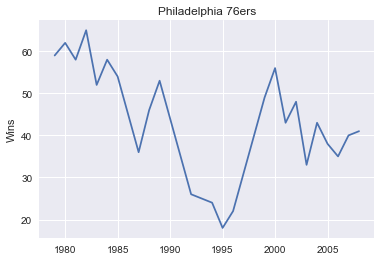

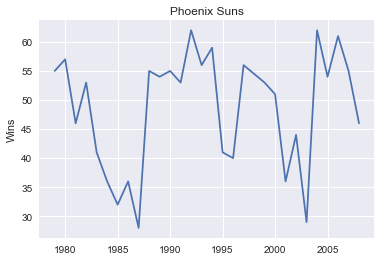

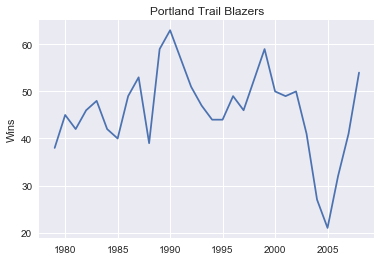

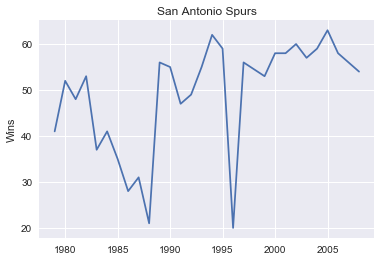

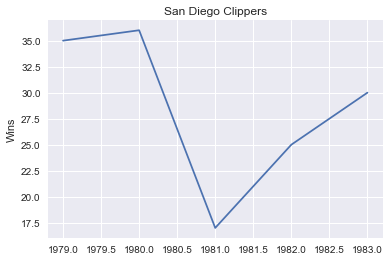

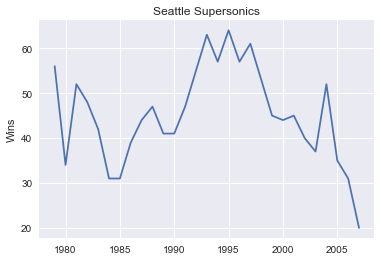

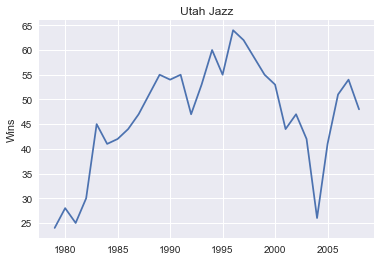

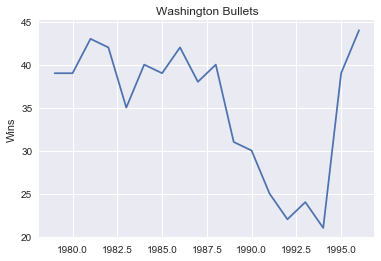

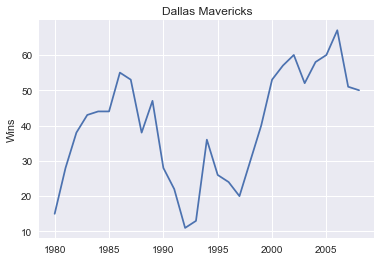

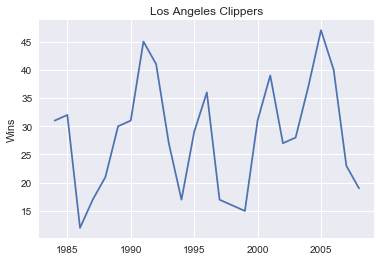

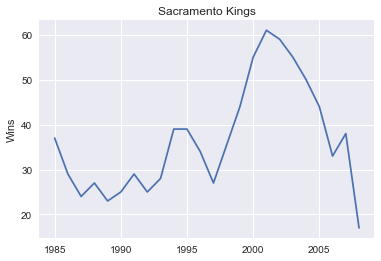

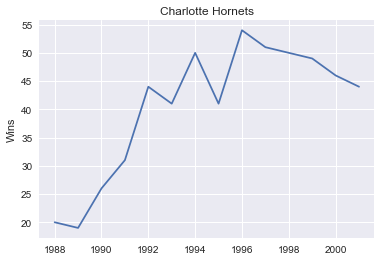

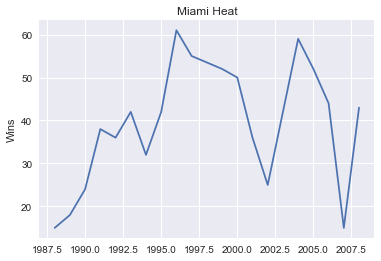

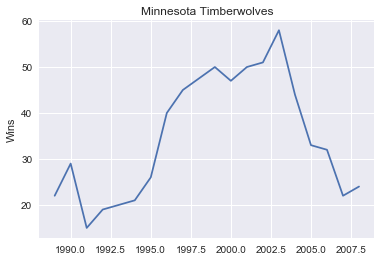

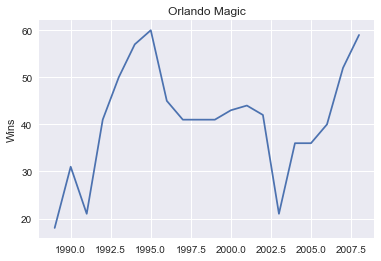

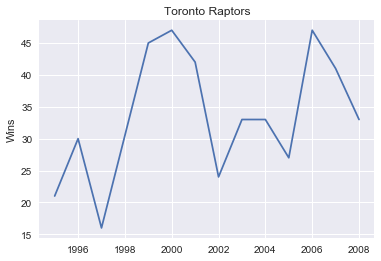

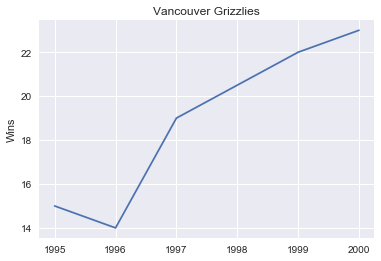

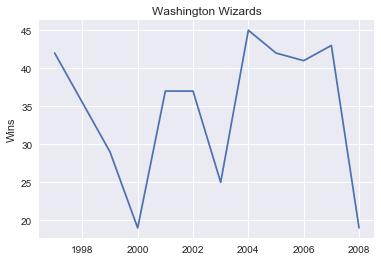

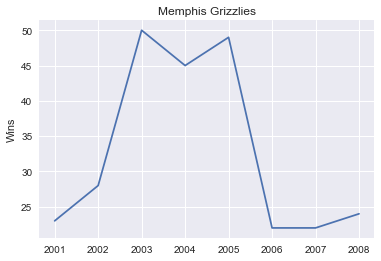

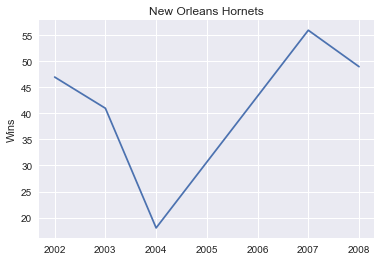

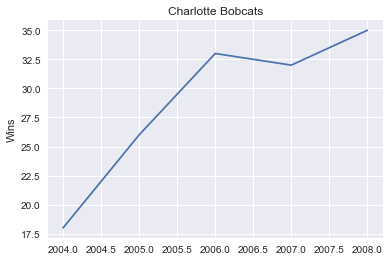

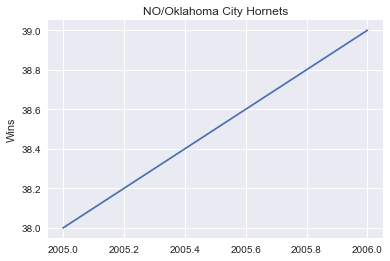

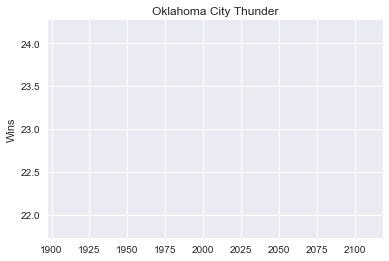

In [630]:
#time series 

for i in df.name.unique():
    df2=df[df.name==i][['year','won']]
    df2.columns=['year', i]
    plt.plot(df2['year'], df2[i], label=i)
    plt.title(i)
    plt.ylabel('Wins')
    plt.show()
#looks like there is time trending in winning per team 

In [631]:
df_temp=pd.DataFrame()

for i, name in enumerate(df.name.unique()):
    df4= df[df.name==name].won.rolling(5, win_type='triang').mean().reset_index()
    df4['year']=df[df.name==name].year.unique()
    df4= df4[['year', 'won']]
    df4.columns=['year','5yearavg']
    df4['name']=name
    if i==0:
        df_temp=df4
    else:
        df_temp=pd.concat([df_temp, df4])
df= pd.merge(df, df_temp, on=['year','name'])
df= df[df.year>=1983] #as the first 5 years will  null values 
df=df.fillna(0)


## Research Question
Now that our data has been cleaned to our liking and we are looking at information we find useful it is important to fully define what we are trying to accomplish. How can raw statistics lead to NBA teams better constructing their rosters and gameplans to try and maximize win totals?

By using a number of predictive and explanatory models we will do our best to attempt to answer this question.

## Choosing a Model

In [632]:
corr = df.corr()
q=corr['winning_season'].sort_values(ascending=False)
#We are sorting the variables with the highest correlation to our Won (1 or 0 variable)
print(q)

winning_season    1.000000
won               0.820929
total_fg          0.617841
total_asts        0.523172
5yearavg          0.490087
total_reb         0.379931
o_dreb            0.351485
o_asts            0.251928
o_pts             0.218187
o_reb             0.208413
o_blk             0.165252
o_stl             0.156418
o_ftm             0.148924
o_fgm             0.139271
d_pf              0.137517
o_fta             0.115657
o_3pm             0.110867
o_3pa             0.085804
d_to              0.048066
d_3pm             0.006392
year             -0.008900
d_fta            -0.026120
d_fga            -0.029672
o_fga            -0.053754
o_oreb           -0.074692
d_oreb           -0.078534
o_pf             -0.205456
d_fgm            -0.213365
d_3pa            -0.228893
d_ftm            -0.234154
d_stl            -0.252382
d_asts           -0.256975
d_reb            -0.270408
o_to             -0.272365
d_dreb           -0.290506
d_pts            -0.301398
d_blk            -0.364980
l

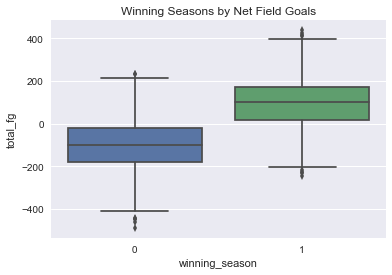

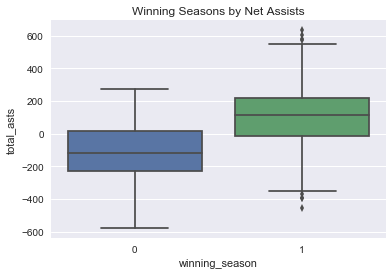

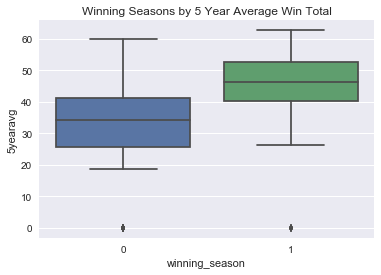

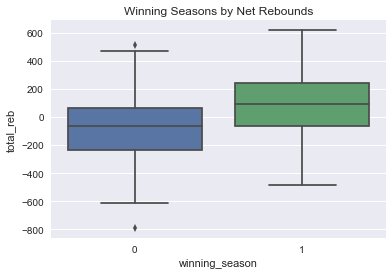

In [593]:
#Top 4 features graphed.
sns.boxplot(x='winning_season', y="total_fg", data=df)
plt.title('Winning Seasons by Net Field Goals')
plt.show()
sns.boxplot(x="winning_season", y="total_asts", data=df)
plt.title('Winning Seasons by Net Assists')
plt.show()
sns.boxplot(x="winning_season", y="5yearavg", data=df)
plt.title('Winning Seasons by 5 Year Average Win Total')
plt.show()
sns.boxplot(x='winning_season', y="total_reb", data=df)
plt.title('Winning Seasons by Net Rebounds')
plt.show()


There are few things to note about our data before we get into testing some models. First it is important to see that "o" in front of our variables refers to offensive and "d" refers to defensive. This makes much more sense when we see the correlation that yes offensive field goals is positively related to wins while defensive field goals allowed is not.

## Logistic Regression

In [594]:
#Top 4 Features
logistic = linear_model.LogisticRegression()
Y = df['winning_season']
X = df[['total_asts','total_fg','total_reb', '5yearavg']]
logistic.fit(X, Y)
Y_pred=logistic.predict(X)

# Inspect the results.
print('\nCoefficients: \n', logistic.coef_)
print('\nIntercept: \n', logistic.intercept_)
print('\nR-squared:')
print(logistic.score(X, Y))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred))
#We decide to add top ten features. 


Coefficients: 
 [[ 0.00142571  0.00944522  0.00091999  0.06265536]]

Intercept: 
 [-2.34377853]

R-squared:
0.801169590643

Confusion Matrix:
[[260  73]
 [ 63 288]]


In [595]:
#Top 10 Features
logistic = linear_model.LogisticRegression()
Y = df['winning_season']
X = df[['o_dreb','o_asts','o_reb','o_pts','o_blk','o_stl','total_asts','total_fg','total_reb', '5yearavg']]
logistic.fit(X, Y)
Y_pred=logistic.predict(X)

# Inspect the results.
print('\nCoefficients: \n', logistic.coef_)
print('\nIntercept: \n', logistic.intercept_)
print('\nR-squared:')
print(logistic.score(X, Y))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred))
#Our model shows some improvement. Let's try adding all the positive features. 


Coefficients: 
 [[ 0.00513553 -0.00255905 -0.00830576  0.00139072  0.00616381  0.00733369
   0.00233958  0.00770389  0.00406382  0.06102158]]

Intercept: 
 [-0.01926297]

R-squared:
0.831871345029

Confusion Matrix:
[[271  62]
 [ 53 298]]


In [596]:
logistic = linear_model.LogisticRegression()
Y = df['winning_season']
X = df[['5yearavg', 'o_dreb','o_asts','o_reb','o_pts','o_blk','o_stl','o_ftm','o_fgm', 'd_pf','o_fta','o_3pm','o_3pa','d_to','d_3pm','total_asts','total_fg','total_reb',]]
logistic.fit(X, Y)
Y_pred=logistic.predict(X)

# Inspect the results.
print('\nCoefficients: \n', logistic.coef_)
print('\nIntercept: \n', logistic.intercept_)
print('\nR-squared:')
print(logistic.score(X, Y))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred))
#Our best model yet with many features. 


Coefficients: 
 [[ 0.05217568  0.00186569  0.00210782 -0.00358143  0.00152864  0.00739354
   0.01766638  0.00780599 -0.00655105  0.00411865 -0.00441492  0.00682476
   0.00072037 -0.01148123 -0.00423562 -0.00170777  0.01735394  0.00135474]]

Intercept: 
 [-0.00036021]

R-squared:
0.868421052632

Confusion Matrix:
[[289  44]
 [ 46 305]]


Our Logistic Regression produced three fairly good models for predicting whether a season was a winning one or not. By using all positively correlated features we created the model with the least mistakes and the highest R-squared. We will look at some other models to see if we can improve even further.

## KNN

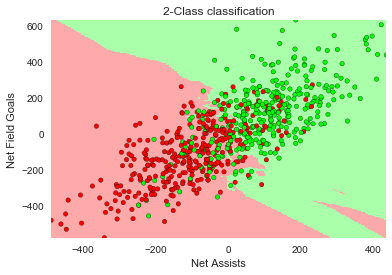

In [600]:
neighbors = KNeighborsClassifier(n_neighbors=10)
X = df[['total_fg','total_asts']]
Y = df.winning_season
neighbors.fit(X,Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
X = np.array(X)
Y = np.array(Y)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
n_neighbors=2
h = 4.0

x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification")
plt.xlabel('Net Assists' )
plt.ylabel('Net Field Goals')
ax= plt.show()

In [601]:
#Testing Our KNN Model with top 4 features and 10 neighbors
neighbors = KNeighborsClassifier(n_neighbors=10)
X = df[['total_asts','total_fg','total_reb','5yearavg']]
Y = df.winning_season
neighbors.fit(X,Y)
Y_pred=neighbors.predict(X)

In [602]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(neighbors, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred))
#A slightly less accurate model compared to logistic regression. Let's try adding more features.

Accuracy: 0.76 (+/- 0.04)

Confusion Matrix:
[[277  56]
 [ 77 274]]


In [603]:
#KNN with top 10 features
neighbors = KNeighborsClassifier(n_neighbors=2)
X = df[['total_asts','total_fg','total_reb','5yearavg','o_dreb','o_asts','o_reb','o_pts','o_blk','o_stl']]
Y = df.winning_season
neighbors.fit(X,Y)
Y_pred=neighbors.predict(X)

In [604]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(neighbors, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred)) 
#By adding more features to our KNN model we are losing accuracy. By sticking with top 4 we have produced the best KNN model

Accuracy: 0.73 (+/- 0.09)

Confusion Matrix:
[[333   0]
 [ 82 269]]


Our KNN models produced slightly less accurate results than our logistic regressions. We will test further models.

## Decision Tree/Random Forest

In [607]:
#Decision Tree 
tree=DecisionTreeClassifier(max_depth=2, max_leaf_nodes=10)
X = df[['total_asts','total_fg','total_reb','5yearavg']]
Y = df.winning_season
X_train, X_test, Y_train,Y_test=train_test_split(X,Y)
tree.fit(X_train, Y_train)
tree.score(X_test,Y_test)

0.82456140350877194

In [609]:
#Random Forest 4 Features
rfc = ensemble.RandomForestClassifier()
X = df[['total_asts','total_fg','total_reb','5yearavg']]
Y = df.winning_season
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=10).mean()

0.78232005845816588

In [610]:
#Random Forest 10 Features
rfc = ensemble.RandomForestClassifier()
X = df[['o_asts','o_reb','o_pts','o_blk','o_stl','o_ftm','total_asts','total_fg','total_reb','5yearavg']]
Y = df.winning_season
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=10).mean()
#Accuracy improves slightly from just 3 features.

0.79536475459749112

In [612]:
#Random Forest All positive Features
rfc = ensemble.RandomForestClassifier()
X = df[['total_asts','total_fg','total_reb','5yearavg', 'o_dreb','o_asts','o_reb','o_pts','o_blk','o_stl','o_ftm','o_fgm', 'd_pf','o_fta','o_3pm','o_3pa','d_to','d_3pm']]
Y = df.winning_season
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=10).mean()

0.81194190719766168

Differing from KNN by adding all the positive features to our Random Forest model we actually improved the accuracy. Despite this our logistic regression model from before still proves to be the most accurate.

## Ridge Regression

In [633]:
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()


In [634]:
#Using all features including new ones.
regr1 = linear_model.LinearRegression()
Y_train = df_train['winning_season']
X_train = df_train.loc[:, ~(df_train.columns).isin(['winning_season','year','name'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))


R-squared simple model:
0.708820322798


In [635]:
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))



0.70866075247


## Lasso Regression

In [636]:
lass = linear_model.Lasso(alpha=.1)
lassfit = lass.fit(X_train, Y_train)
print('R² ')
print(lass.score(X_train, Y_train))

R² 
0.703659823959


C:\Users\Connor\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Both our Ridge and Lasso regressions, while objectively good models, are not as accurate as our original logistic regression

## In Conclusion

After running a number of models our logisical regression that uses all of our positively correlated statistics seems to be the most accurate. Having an r squared of about 87% percent our model made very few errors in predicting whether a season would be winning or losing. Despite this our model is very far from perfect of course. We will conclude why, and suggest methods for future studies in the next section.

## Future Study

Our data presents the problem of being unable to use current season data as is and instituting it into our model. To solve this problem we can predict full season values of stats by putting it into the formula 82c/g =p where c is the value of our current stat, g is the value of current amount of games played, and p will be the projected value of the stat over 82 games. This would give us the value of the stat for a full statistic and then use that number to feed into our model. However, an easier way to solve this problem would be to institute our model as a time series where we can predict future seasons with current data. In my further studies I hope to be able to revisit this model and come up with an improved one which will allow us to do so.